## 단계1. 라이브러리/데이터 불러오기

###  1.1 라이브러리 불러오기

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

### 1.2 데이터 불러오기

In [3]:
data = pd.read_csv('InjectionMolding_Raw_Data.csv')     # 데이터 불러와 data 변수에 저장장

## 단계 2. 데이터 확인

In [4]:
data.columns            # 데이터 컬럼명 확인

Index(['No_Shot', 'Machine_Cycle_Time', 'Cycle_Time', 'Barrel_Temp_Z1',
       'Barrel_Temp_Z2', 'Barrel_Temp_Z3', 'Barrel_Temp_Z4', 'Hopper_Temp',
       'Injection_Pressure_Real_Time', 'Screw_Position',
       'Injection_Peak_Press', 'Max_Injection_Rate', 'Screw_Velocity',
       'VP_Time', 'VP_Position', 'Weighing_Start_Position', 'VP_Press',
       'Plasticizing_Time', 'Plasticizing_Start_Position',
       'Plasticizing_End_Position', 'Plasticizing_RPM', 'Minimum_Cushion',
       'Cooling_Time', 'Back_Flow', 'Decompression_Time', '_ID'],
      dtype='object')

In [5]:
data.info()         
# 데이터를 구성하는 컬럼명, 결측치가 아닌 개수, 데이터의 타입을 컬럼별로 나눠서 확인

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030635 entries, 0 to 1030634
Data columns (total 26 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   No_Shot                       1030635 non-null  int64  
 1   Machine_Cycle_Time            1030635 non-null  float64
 2   Cycle_Time                    1030635 non-null  float64
 3   Barrel_Temp_Z1                1030635 non-null  float64
 4   Barrel_Temp_Z2                1030635 non-null  float64
 5   Barrel_Temp_Z3                1030635 non-null  float64
 6   Barrel_Temp_Z4                1030635 non-null  float64
 7   Hopper_Temp                   1030635 non-null  float64
 8   Injection_Pressure_Real_Time  1030635 non-null  float64
 9   Screw_Position                1030635 non-null  float64
 10  Injection_Peak_Press          1030635 non-null  float64
 11  Max_Injection_Rate            1030635 non-null  float64
 12  Screw_Velocity              

In [6]:
data.count()
# 각 컬럼별 데이터 개수를 확인

No_Shot                         1030635
Machine_Cycle_Time              1030635
Cycle_Time                      1030635
Barrel_Temp_Z1                  1030635
Barrel_Temp_Z2                  1030635
Barrel_Temp_Z3                  1030635
Barrel_Temp_Z4                  1030635
Hopper_Temp                     1030635
Injection_Pressure_Real_Time    1030635
Screw_Position                  1030635
Injection_Peak_Press            1030635
Max_Injection_Rate              1030635
Screw_Velocity                  1030635
VP_Time                         1030635
VP_Position                     1030635
Weighing_Start_Position         1030635
VP_Press                        1030635
Plasticizing_Time               1030635
Plasticizing_Start_Position     1030635
Plasticizing_End_Position       1030635
Plasticizing_RPM                1030635
Minimum_Cushion                 1030635
Cooling_Time                    1030635
Back_Flow                       1030635
Decompression_Time              1030635


## 단계3. 데이터 전처리

### 3.1 결측치 처리, 3.2 분석에 사용하지 않는 변수 제거

In [7]:
print('결측치 개수:',data[data.isnull()==True].count().sum())
# 데이터 결측치 개수를 확인. (Null 값 존재 여부 확인)  / 결측치 개수 0개 -> 제거 불필요

data_drop = data.copy().drop(['Minimum_Cushion','Weighing_Start_Position','_ID'],axis=1)
# 분석에 사용하지 않는 변수 제거
# Minimum_Cushion : 스크류 앞에 남은 플라스틱 양 -> 모두 양수 값
#                   재료는 충분히 투입되어 있다 판단하여 제거
# Weighing_Start_Position : 계량 시작 위치 -> 공정이 끝나고 다음 사이클을 위해 계량을 시작하는 위치
#                           공정에 영향 X
# _ID : 데이터 고유 아이디 -> 분석에 불필요

결측치 개수: 0


### 3.3 Lot 단위 데이터 정리

In [8]:
# Lot별 분리함수
# Lot을 판단할 수 있는 공정변수 'No_Shot'을 기준으로 분리하여 리스트에 저장
def to_lot(data):
    lot_list = [0,data.shape[0]]        # 슬라이싱을 위한 시작 인덱스와 끝 인덱스 초기화

    for i in range(data.shape[0]):      # No_Shot 컬럼의 모든 값에서
        if data['No_Shot'][i] == 0:     # No_Shot 값이 0인 인덱스를 찾아
            lot_list.append(i)          # lot_list에 추가

    lot_list.sort()                     # lot_list 오름차순 정렬

    data_lot = []

    for i in range(len(lot_list)-1):        # lot_list의 인덱스 범위만큼 반복
        data_lot.append(data.iloc[lot_list[i]:lot_list[i+1]])       # lot_list의 인덱스 구간을 슬라이싱하여 data_lot 리스트에 추가

    return data_lot


In [9]:
# Lot별 분리 함수 적용
data_lot=to_lot(data_drop)

In [10]:
# 데이터 갯수가 100 미만인 Lot 제거 함수
# 100개 미만일 경우 분석을 하기에 적은 표본이라 판단하여 제거
def error_drop(data_lot):

    normal_lot = []

    for i in range(len(data_lot)):          # 입력받은 data_lot 리스트의 길이만큼 반복   
        if data_lot[i].shape[0]>=100:       # 각 Lot의 데이터 개수가 100개 이상일 경우에만
            normal_lot.append(data_lot[i])  # normal_lot 리스트에 추가

    return normal_lot

In [11]:
# 분석에 사용할 Lot 데이터
# 이상치 제거 함수 적용

data_n_lot=error_drop(data_lot)

## 단계 4. 데이터 특성 파악

### 4.1 데이터 시각화

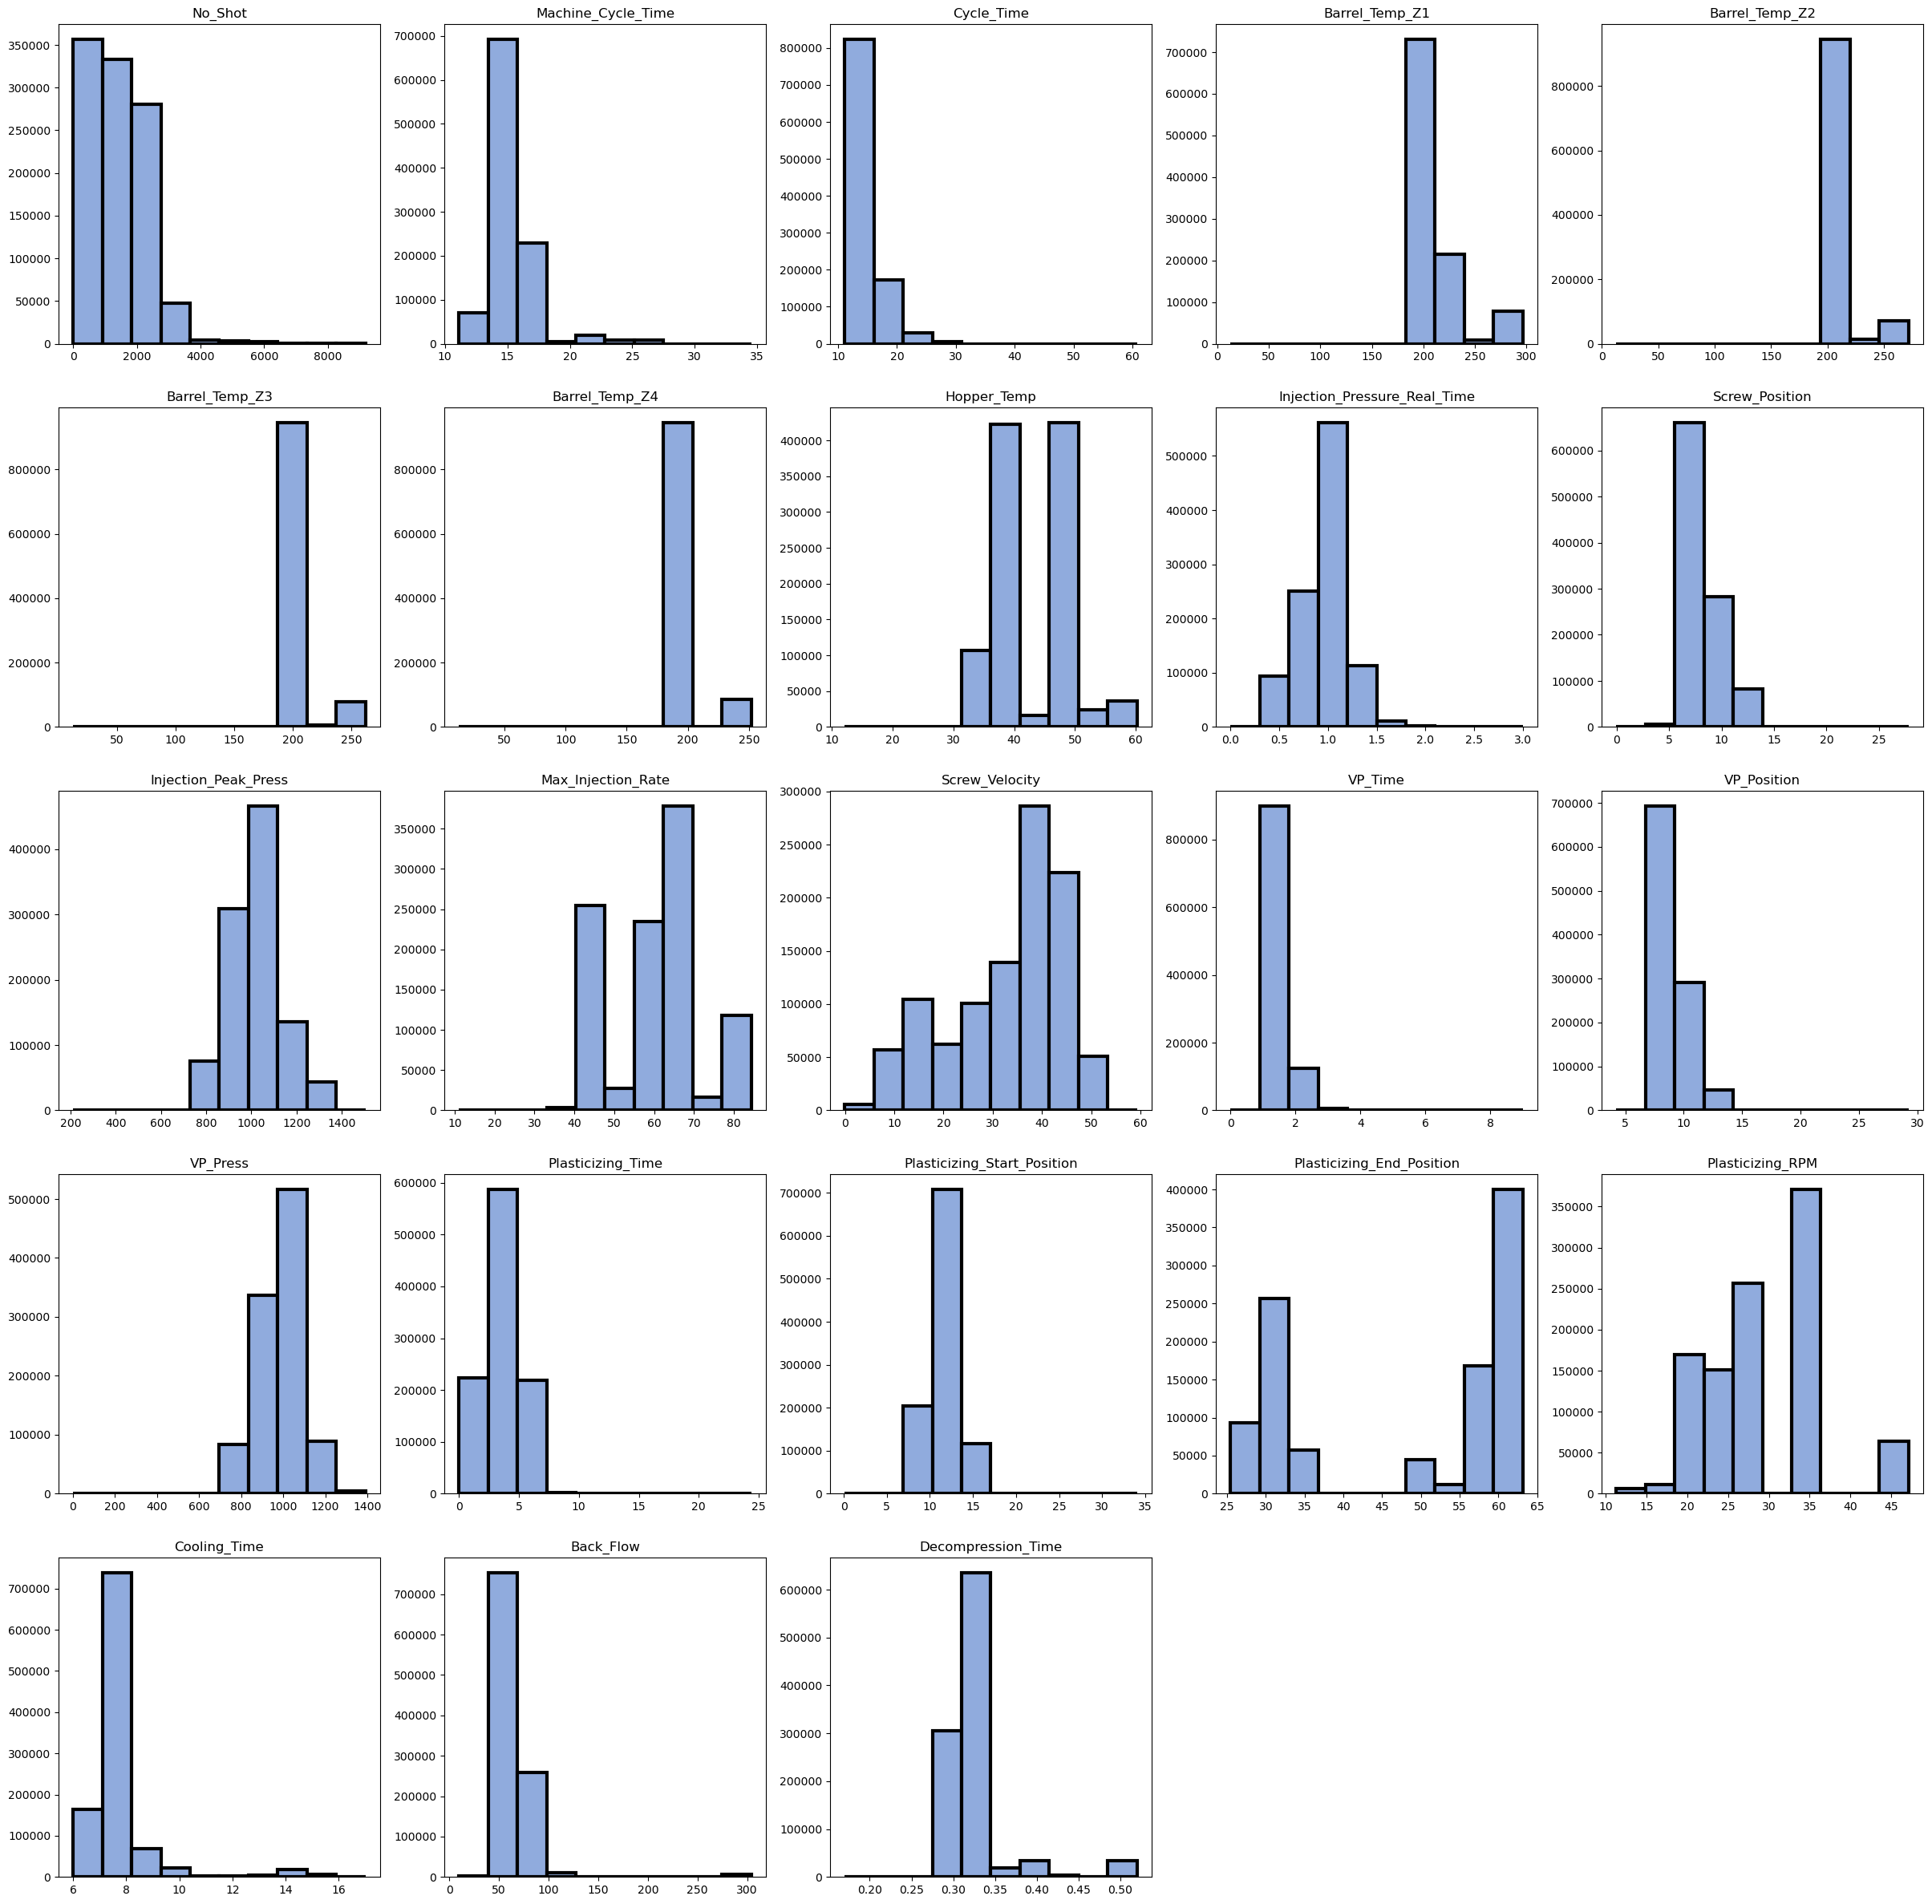

In [12]:
# 히스토그램 시각화
plt.figure(figsize=(30,30))

for index,value in enumerate(data_drop):        # value(컬럼명)과 index(인덱스)를 하나씩 꺼내며 반복
    sub=plt.subplot(5,5,index+1)                # 5x5 그리드의 index+1번째 자리에 위치 지정
    sub.hist(data_drop[value], facecolor = (144/255, 171/255, 221/255), linewidth=3, edgecolor='black')
    #히스토그램 그리기(연한파랑), 검정색 테두리 3pt
    plt.title(value)        # 각 그래프 상단에 해당 컬럼 이름을 제목으로 표시

### 4.2 데이터 상관분석

<Axes: >

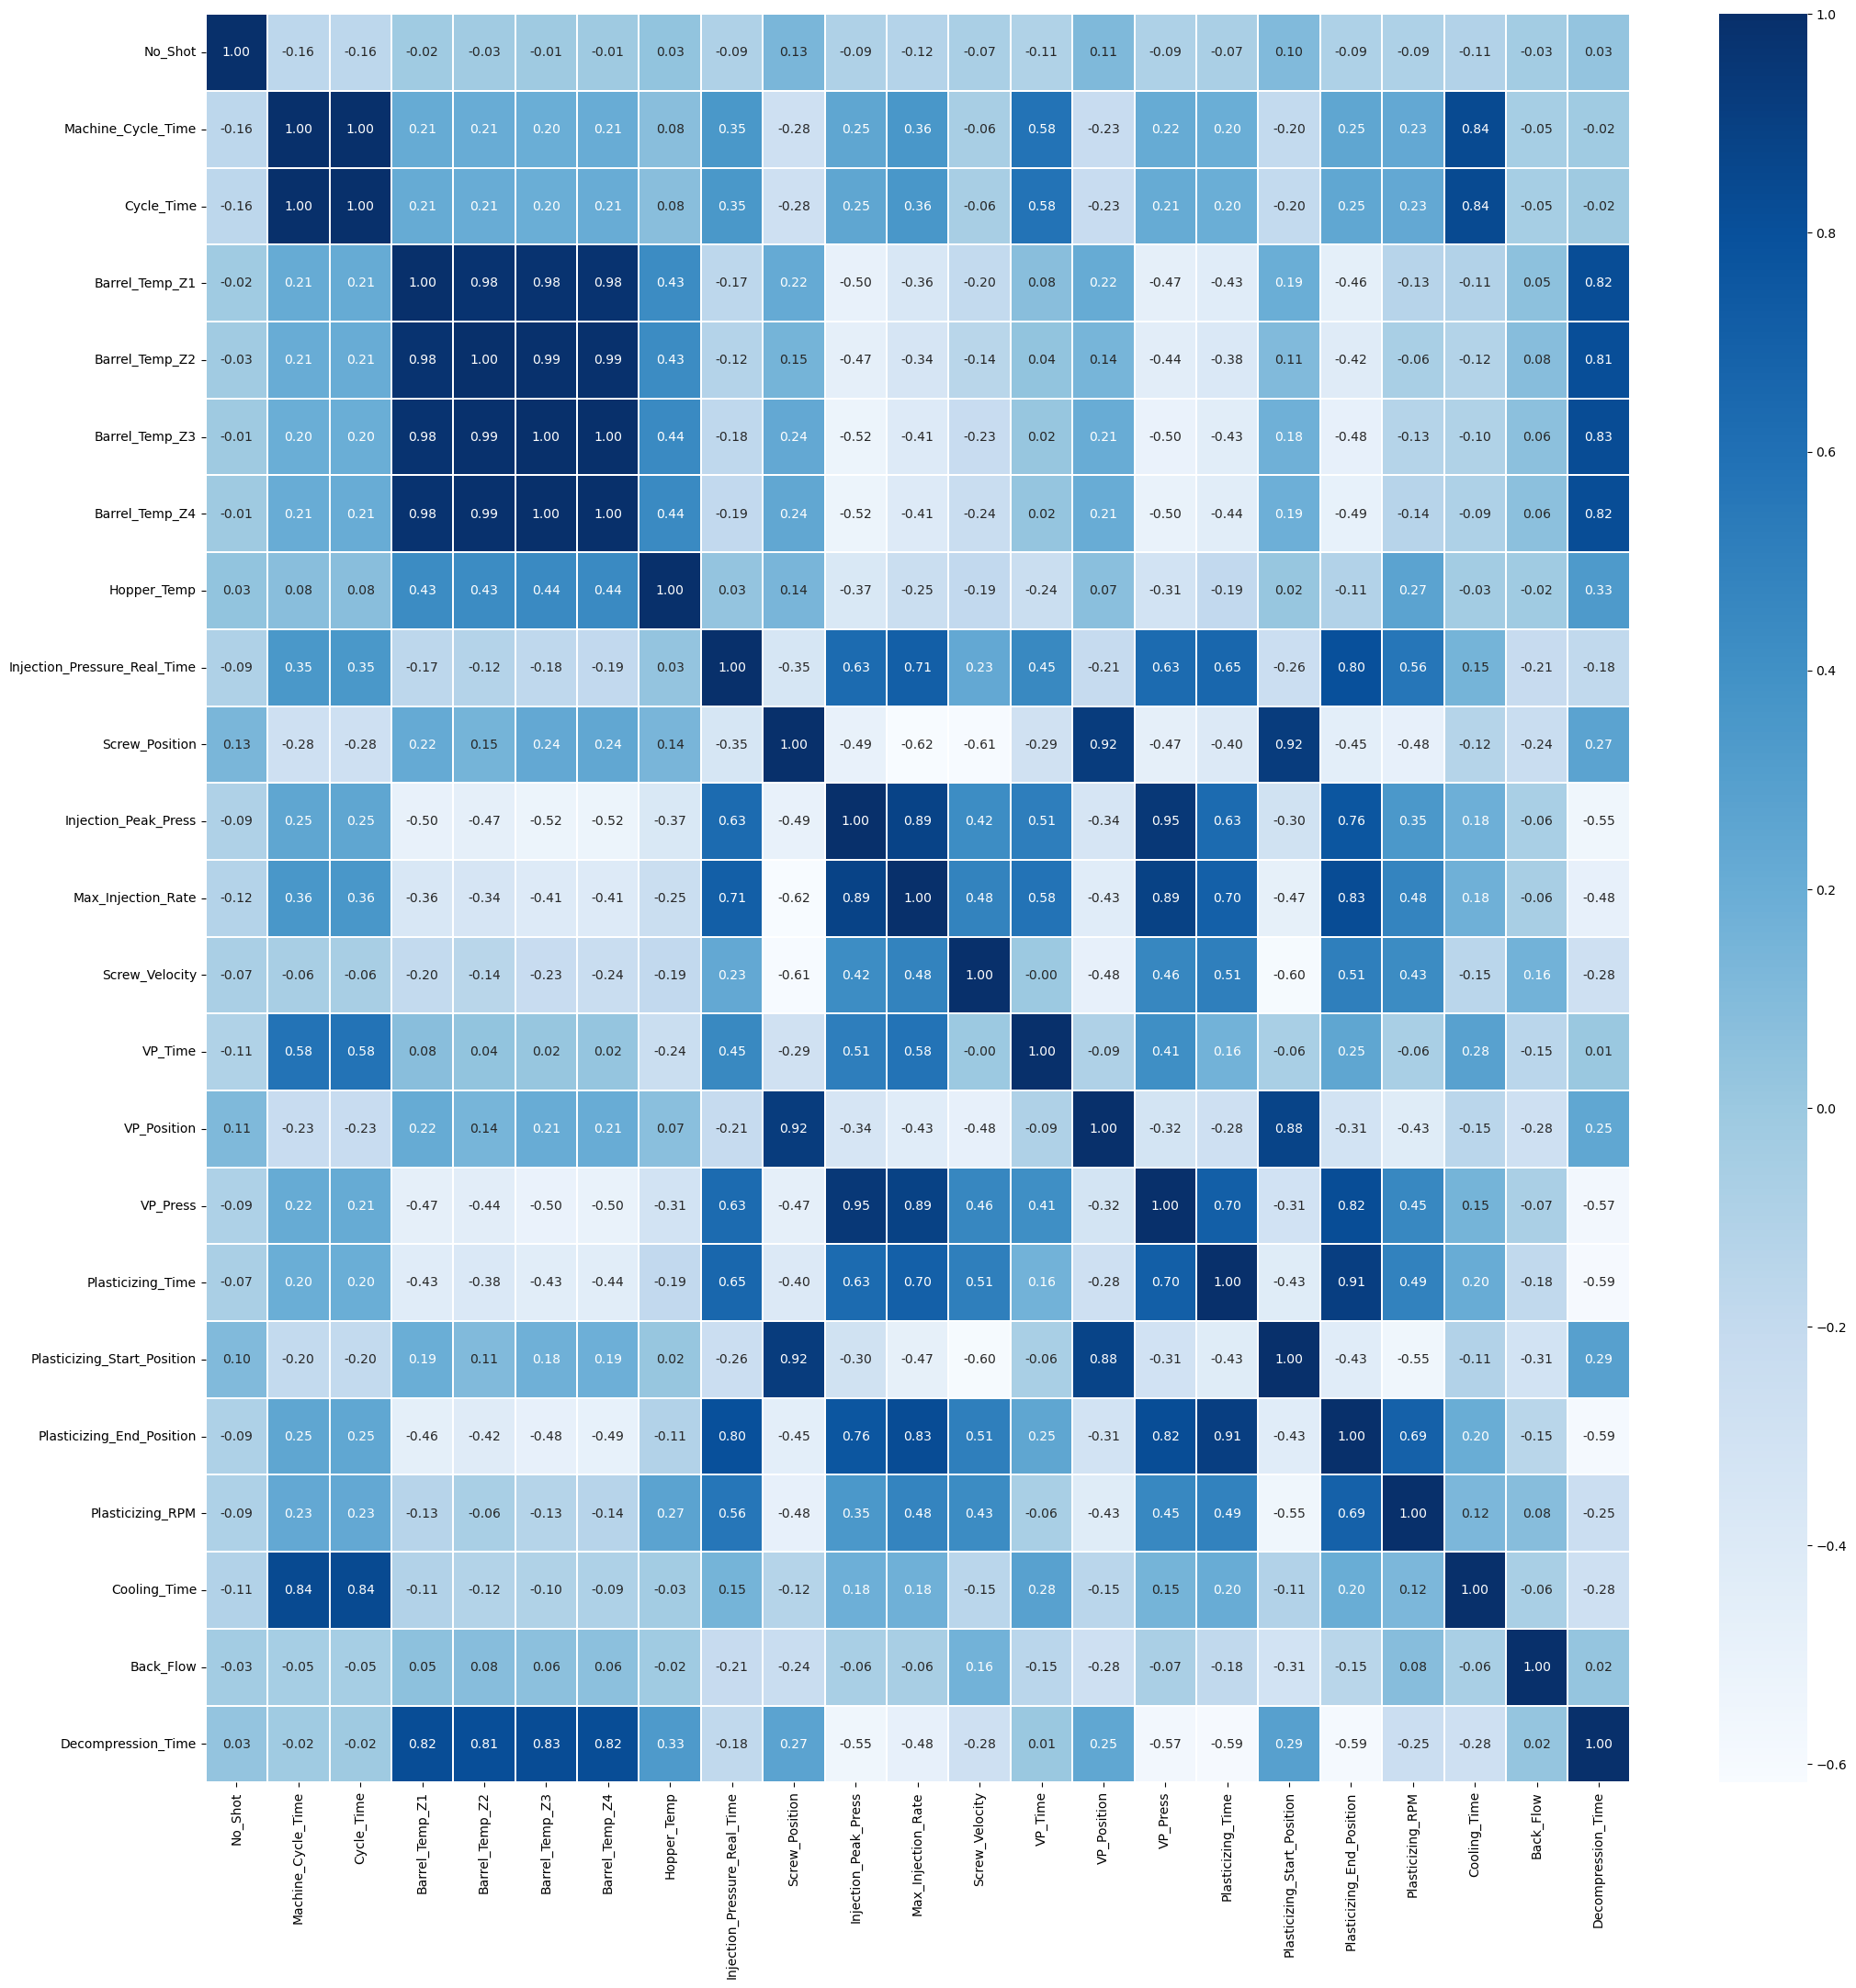

In [13]:
# 상관계수 시각화

plt.subplots(figsize=(25,25))
# data.corr() : 각 컬럼별 상관계수 계산
# annot=True : 각 셀에 상관계수 수치 표시
# fmt='.2f' : 소수점 둘째자리까지 표시
# cmap='Blues' : 1에 가까울 수록 진한 파란색으로 표시

sns.heatmap(data=data_drop.corr(), linewidths=0.1, annot=True, fmt='.2f', cmap='Blues')

## 단계 5. 데이터 분류

### 5.1.1 Lot 단위 대표값 추출

In [14]:
# Lot별 대표값 데이터 프레임
# 대표값은 평균으로

data_list = []

# 분리된 각 Lot 데이터프레임 순회
for i in range(len(data_n_lot)):                
    data_list.append(data_n_lot[i].mean())      # 계산된 평균값을 data_list 리스트에 추가


lot_mean=pd.DataFrame(data_list).drop(['No_Shot'], axis=1)
# data_list를 데이터프레임으로 변환. No_Shot은 식별자이므로 제거

In [15]:
# Lot별 평균값 데이터프레임 확인
lot_mean.head()

,Machine_Cycle_Time,Cycle_Time,Barrel_Temp_Z1,Barrel_Temp_Z2,Barrel_Temp_Z3,Barrel_Temp_Z4,Hopper_Temp,Injection_Pressure_Real_Time,Screw_Position,Injection_Peak_Press,...,VP_Time,VP_Position,VP_Press,Plasticizing_Time,Plasticizing_Start_Position,Plasticizing_End_Position,Plasticizing_RPM,Cooling_Time,Back_Flow,Decompression_Time
0,16.668679,16.681723,209.998316,200.042358,194.962824,189.962435,40.085622,1.367863,6.535635,1259.353666,...,2.0,8.119780,1184.873031,4.797461,11.008510,63.111632,28.27,8.0,49.03,0.322306
1,16.660866,16.677780,209.999803,200.038804,195.007241,190.018890,40.089532,1.363695,6.509563,1270.757599,...,2.0,8.119437,1161.965710,4.789536,11.000386,63.111625,28.27,8.0,49.03,0.321893
2,16.681288,16.699753,209.996035,200.036514,195.001296,190.016765,40.078406,1.382933,6.640133,1252.482285,...,2.0,8.121991,1184.553149,4.684229,11.087640,63.111457,28.27,8.0,49.03,0.321735
3,16.634533,16.653553,209.998039,200.040196,195.001059,190.008471,40.090627,1.338847,6.524275,1244.939608,...,2.0,8.123667,1113.798486,4.731149,11.006322,63.111573,28.27,8.0,49.03,0.321718
4,16.610939,16.624291,209.996946,200.031504,195.009702,190.020371,40.125474,1.308349,6.465195,1239.340870,...,2.0,8.124291,1109.827781,4.630274,10.976884,63.111736,28.27,8.0,49.03,0.321701


In [16]:
# Lot별 대표값 데이터프레임
# 대표값은 중앙값으로

data_list=[]

# 분리된 각 Lot 데이터프레임 순회
for i in range(len(data_n_lot)):               
    data_list.append(data_n_lot[i].median())    # 계산된 중앙값을 data_list 리스트에 추가

lot_median = pd.DataFrame(data_list).drop('No_Shot',axis=1)
# data_list를 데이터프레임으로 변환. No_Shot은 식별자이므로 제거

In [17]:
# Lot별 중앙값 데이터프레임 확인
lot_median.head()

,Machine_Cycle_Time,Cycle_Time,Barrel_Temp_Z1,Barrel_Temp_Z2,Barrel_Temp_Z3,Barrel_Temp_Z4,Hopper_Temp,Injection_Pressure_Real_Time,Screw_Position,Injection_Peak_Press,...,VP_Time,VP_Position,VP_Press,Plasticizing_Time,Plasticizing_Start_Position,Plasticizing_End_Position,Plasticizing_RPM,Cooling_Time,Back_Flow,Decompression_Time
0,16.68,16.68,210.0,200.1,195.0,190.0,40.1,1.38,6.53,1257.17,...,2.0,8.12,1186.15,4.79,11.01,63.11,28.27,8.0,49.03,0.32
1,16.66,16.68,210.0,200.0,195.0,190.0,40.1,1.37,6.51,1272.76,...,2.0,8.12,1161.52,4.79,11.01,63.11,28.27,8.0,49.03,0.32
2,16.70,16.70,210.0,200.0,195.0,190.0,40.1,1.39,6.65,1245.58,...,2.0,8.12,1196.07,4.72,11.08,63.11,28.27,8.0,49.03,0.32
3,16.64,16.66,210.0,200.0,195.0,190.0,40.1,1.34,6.53,1241.34,...,2.0,8.12,1112.63,4.74,11.01,63.11,28.27,8.0,49.03,0.32
4,16.62,16.62,210.0,200.0,195.0,190.0,40.1,1.31,6.47,1231.23,...,2.0,8.12,1111.26,4.63,10.98,63.11,28.27,8.0,49.03,0.32


In [18]:
# Lot별 대표값 데이터프레임
# 대표값은은 3분위수로

data_list=[]

# 분리된 각 Lot 데이터프레임 순회
for i in range(len(data_n_lot)):                    
    data_list.append(data_n_lot[i].quantile(.75))   # 계산된 3분위수를 data_list 리스트에 추가

lot_75=pd.DataFrame(data_list).drop(['No_Shot'],axis=1).reset_index(drop=True)
# data_list를 데이터프레임으로 변환. No_Shot은 식별자이므로 제거

In [19]:
# Lot별 3분위수 데이터프레임 확인
lot_75.head()

,Machine_Cycle_Time,Cycle_Time,Barrel_Temp_Z1,Barrel_Temp_Z2,Barrel_Temp_Z3,Barrel_Temp_Z4,Hopper_Temp,Injection_Pressure_Real_Time,Screw_Position,Injection_Peak_Press,...,VP_Time,VP_Position,VP_Press,Plasticizing_Time,Plasticizing_Start_Position,Plasticizing_End_Position,Plasticizing_RPM,Cooling_Time,Back_Flow,Decompression_Time
0,16.68,16.70,210.0,200.1,195.1,190.1,40.2,1.39,6.58,1272.2925,...,2.0,8.13,1201.43,4.82,11.050,63.11,28.27,8.0,49.03,0.32
1,16.68,16.70,210.0,200.1,195.1,190.1,40.2,1.38,6.56,1284.7400,...,2.0,8.13,1178.11,4.82,11.050,63.11,28.27,8.0,49.03,0.32
2,16.70,16.72,210.0,200.1,195.1,190.1,40.2,1.40,6.71,1263.9100,...,2.0,8.13,1223.25,4.77,11.145,63.11,28.27,8.0,49.03,0.32
3,16.66,16.66,210.0,200.1,195.1,190.1,40.2,1.35,6.57,1257.4200,...,2.0,8.13,1123.48,4.77,11.050,63.11,28.27,8.0,49.03,0.32
4,16.62,16.64,210.0,200.1,195.1,190.1,40.2,1.31,6.52,1255.4300,...,2.0,8.13,1125.98,4.65,11.030,63.11,28.27,8.0,49.03,0.32


In [20]:
# Lot별 대표값 데이터프레임
# 대표값은은 1분위수로

data_list=[]

# 분리된 각 Lot 데이터프레임 순회
for i in range(len(data_n_lot)):
    data_list.append(data_n_lot[i].quantile(.25))   # 계산된 1분위수를 data_list 리스트에 추가

lot_25=pd.DataFrame(data_list).drop(['No_Shot'],axis=1).reset_index(drop=True)
# data_list를 데이터프레임으로 변환. No_Shot은 식별자이므로 제거

In [21]:
# Lot별 1분위수 데이터프레임 확인
lot_25.head()

,Machine_Cycle_Time,Cycle_Time,Barrel_Temp_Z1,Barrel_Temp_Z2,Barrel_Temp_Z3,Barrel_Temp_Z4,Hopper_Temp,Injection_Pressure_Real_Time,Screw_Position,Injection_Peak_Press,...,VP_Time,VP_Position,VP_Press,Plasticizing_Time,Plasticizing_Start_Position,Plasticizing_End_Position,Plasticizing_RPM,Cooling_Time,Back_Flow,Decompression_Time
0,16.66,16.66,210.0,200.0,194.9,189.9,40.0,1.35,6.50,1245.58,...,2.0,8.11,1169.25,4.76,10.97,63.11,28.27,8.0,49.03,0.32
1,16.64,16.66,210.0,200.0,194.9,189.9,40.0,1.35,6.47,1258.92,...,2.0,8.11,1148.05,4.76,10.96,63.11,28.27,8.0,49.03,0.32
2,16.66,16.68,210.0,200.0,194.9,189.9,40.0,1.37,6.56,1237.84,...,2.0,8.11,1156.91,4.59,11.02,63.11,28.27,8.0,49.03,0.32
3,16.64,16.64,210.0,200.0,194.9,189.9,40.0,1.33,6.49,1227.40,...,2.0,8.11,1103.03,4.70,10.96,63.11,28.27,8.0,49.03,0.32
4,16.60,16.62,210.0,200.0,194.9,190.0,40.0,1.30,6.41,1221.13,...,2.0,8.12,1094.42,4.60,10.92,63.11,28.27,8.0,49.03,0.32


### 5.1.2 IQR(사분위범위)기반 abnormal 데이터 정의

In [22]:
# IQR을 통한 이상치 분류 함수

def outliers_iqr(data):
    q1, q3= np.percentile(data,[25, 75])    # 데이터의 1사분위수, 3사분위수 산출
    iqr = q3 - q1                           # IQR 계산 (전체 데이터의 중간 50%가 분포하는 범위)
    lower_bound = q1 - (iqr*1.5)            # 이상치 하한선 계산
    upper_bound = q3 + (iqr*1.5)            # 이상치 상한선 계산

    return np.where((data>upper_bound)|(data<lower_bound))  
    # 상한선 초과하거나 하한선 미만인 데이터 반환

In [23]:
# Lot별 대표값을 통한 abnormal 탐색 함수
# 각 컬럼별 이상치가 4개 이상인 Lot 번호(index)를 abnormal이라 판단

def outlier_search(lot_rep):

    rep_index = []
    # 이상치로 판명된 Lot의 인덱스 저장할 리스트 초기화
    
    for i in range(lot_rep.shape[1]):           # 모든 컬럼을 순회하며 IQR 이상치 탐지
        rep_index.append(outliers_iqr(lot_rep[lot_rep.columns[i]])[0])
        # 해당 컬럼에서 이상치로 검출된 Lot의 인덱스를 추출하여 저장

    outlier_index = []      # 최종 불량으로 판단된 Lot의 인덱스를 담을 리스트 초기화

    for i in range(len(lot_rep)):       # 이상치 목록을 확인
        a = 0                           # 이상치 개수 카운트 초기화
        for j in rep_index:             # 앞서 구한 컬럼별 이상치 목록 확인
            if i in j:                  # 현재 검사중인 Lot 번호가 해당 컬럼의 이상치 목록에 포함되어 있는지 확인
                a = a + 1               # 포함되어 있다면 카운트 1 증가
        if a > 3:                       # 이상치 개수가 4개 이상이면
            outlier_index.append(i)     # 최종 불량으로 판단, 리스트에 추가

    return outlier_index

In [24]:
# 각 대표값 별 abnormal 합집합

IQR_error=sorted((list(set(outlier_search(lot_mean)+outlier_search(lot_median)+
                           outlier_search(lot_75)+outlier_search(lot_25)))))
# 다양한 대표값에서 검출된 이상치 판단
# 하나의 기준에서라도 이상치로 판별되면 불량으로 판단

In [25]:
# IQR을 통한 abnormal Lot 번호 확인
print(IQR_error)
# 최종 불량 리스트 확인

[85, 86, 87, 88, 89, 90, 91, 92, 93, 97, 100, 101, 102, 103, 113, 114, 325, 328, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380]


### 5.1.3 DBSCAN 기반 abnormal 데이터 정의

In [26]:
# x: 독립변인들의 value값만 추출
# y: 종속변인 추출

x = lot_mean.drop(['Machine_Cycle_Time'],axis=1).values
# Machine_Cycle_Time을 제외한 모든 컬럼의 값들을 x에 저장

y = lot_mean['Machine_Cycle_Time'].values
# Machine_Cycle_Time 컬럼의 값들을 y에 저장

In [27]:
# x객체에 x를 표준화한 데이터를 저장
x = MinMaxScaler().fit_transform(x)

# MinMaxScaler를 사용하여 x 데이터를 0~1 사이로 표준화
# 시각화 하기위한 과정

In [28]:
# 2개의 주성분(n_components)으로 이루어진 데이터프레임 구성

pca = PCA(n_components=2)
# 데이터를 2개의 축으로 차원 축소

printcipalComponents = pca.fit_transform(x)
# 정규화된 x데이터를 입력받아 2차원으로 변환

principalDF = pd.DataFrame(data=printcipalComponents, columns = ['principal component1','principal component2'])
# 시각화 및 관리를 하기 위해 행렬 데이터를 DataFrame으로 변환


In [29]:
# PCA를 통한 차원축소 결과 확인
principalDF.head()

,principal component1,principal component2
0,0.873603,0.343205
1,0.865574,0.340311
2,0.837708,0.320043
3,0.785490,0.296093
4,0.766725,0.286019


In [30]:
# epsilon, 최소 샘플 개수 설정
# 모델을 DBSCAN 알고리즘 사용

a = 0.165
# 0.165 안에 있는 점들을 하나의 군집으로 설정

b = 10
# 최소 10개의 점이 모여야 군집으로 인식

model = DBSCAN(eps=a,min_samples=b)

In [31]:
# 군집화 모델 학습 및 클러스터 예측 결과 반환
model.fit(principalDF)
# 데이터 포인트 간의 거리를 계산하여 밀도가 높은 핵심 영역을 찾음

principalDF['cluster'] = model.fit_predict(principalDF)
# 각 데이터가 몇 번 군집에 속하는지 라벨링 수행

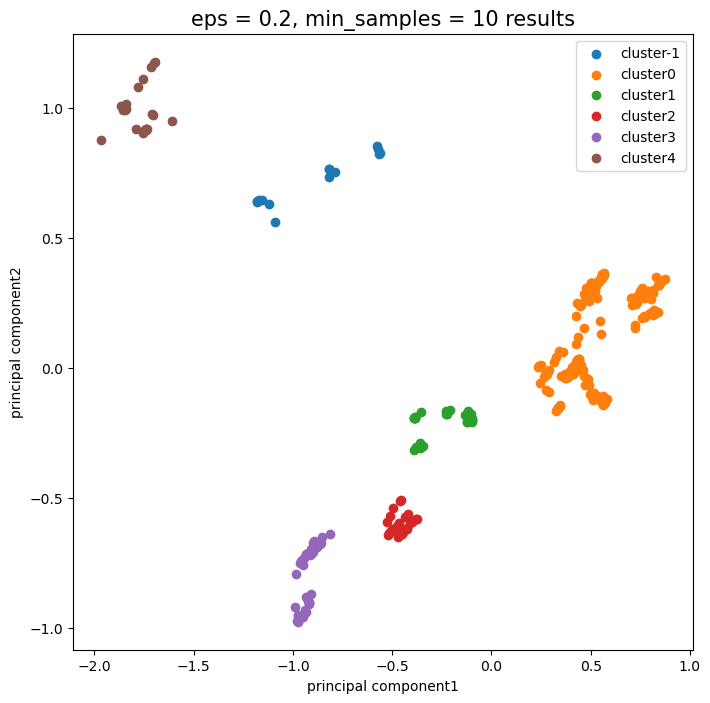

In [32]:
# matplotlib 라이브러리를 통한 군집 시각화
# 이상치 번호는 -1, 클러스터 최대 숫자까지 iteration

plt.figure(figsize=(8,8))

# -1은 이상치를 의미하므로 반복범위를 -1부터 최대 클러스터 번호까지 설정
for i in range(-1, principalDF['cluster'].max()+1):

    # 현재 순회중인 군집의 데이터만 필터링 하여 산점도 그리기    
    plt.scatter(principalDF.loc[principalDF['cluster'] == i, 'principal component1'],
                principalDF.loc[principalDF['cluster'] == i, 'principal component2'],
                label = 'cluster' + str(i))
                # x축, y축, 범례 설정

plt.legend()
plt.title('eps = %.1f, min_samples = %d results'%(a,b), size=15)
# 제목 설정 eps: 반경, min_samples: 최소 샘플 개수
plt.xlabel('principal component1', size=10) # x축 이름
plt.ylabel('principal component2', size=10) # y축 이름
plt.show()

In [33]:
# DBSCAN을 통해 발견한 abnormal 예상 Lot 분류

# 불량 Lot 번호 저장 리스트 초기화
DB_error=[]

for i in range(len(principalDF)):
# 데이터프레임을 순회하며 군집 번호 확인
    if principalDF['cluster'][i] == 4:
    # 정상군집과 거리가 먼 4번 그룹 불량 판단 
        DB_error.append(i)

    elif principalDF['cluster'][i]==-1:
    # 돌발형 이상치 -1번 그룹 불량 판단
        DB_error.append(i)

### 5.1.4 최종 결과 abnormal Lot

In [34]:
# IQR을 통한 abnormal Lot 번호와 DBSCAN을 통한 abnormal Lot 번호의 합집합
# 총 43개의 Lot을 abnormal이라 판단

error_list = sorted(list(set(IQR_error + DB_error)))
# 두 방법으로 검출된 이상치 Lot 번호를 합집합 하여 중복 제거 및 정렬

print('abnormal Lot 번호:', error_list)
print('abnormal Lot 개수:', len(error_list))
# 최종 불량 리스트 확인 및 개수 확인

abnormal Lot 번호: [85, 86, 87, 88, 89, 90, 91, 92, 93, 97, 100, 101, 102, 103, 113, 114, 325, 328, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380]
abnormal Lot 개수: 43


### 5.1.5 설비 normal/abnormal 레이블 부여

In [35]:
n_Lot_list = []

for i in range(len(data_n_lot)):
# 분리되어 있는 Lot 데이터프레임을 순회
    
    a = i
    # 현재 리스트 인덱스를 Lot 번호로 설정
    
    Lot_label = data_n_lot[i].copy()
    # 원본 데이터 오염 방지를 위해 복사본 생성
    
    Lot_label.loc[:,['Lot']] = a
    # Lot 이라는 새 컬럼을 만들고, 해당 번호를 모든 행에 일괄 입력 
    
    n_Lot_list.append(Lot_label)
    # 라벨링이 완료된 데이터프레임을 새 리스트에 저장

In [36]:
# concat 함수를 통한 데이터 결합

data_lot_label = n_Lot_list[0]
# 데이터의 첫 번째 Lot 데이터를 기준으로 설정

for i in range(len(n_Lot_list)):
# 리스트에 있는 모든 Lot 순회
    if i == 0:
    # 0번 인덱스는 초기값 설정 하였으므로 중복 방지를 위해 패스
        pass
    else:
        data_lot_label = pd.concat([data_lot_label,n_Lot_list[i]])
        # 기존 데이터 이래에 현재 순번의 Lot 데이터를 병합

data_lot_label = data_lot_label.reset_index(drop=True)
# 여러 데이터를 합치는 과정에서 뒤섞인 인덱스 번호를 0부터 순서대로 부여
# drop=True 옵션을 통해 기존 인덱스 번호는 삭제

In [37]:
# abnormal shot 라벨링

data_lot_label.loc[:,['PassOrFail']]=0
# 모든 데이터를 0(정상)으로 초기화

for i in range(len(data_lot_label)):
# 전체 데이터를 순회하며 검사
    if data_lot_label['Lot'][i] in error_list:
    # 현재 데이터의 Lot 번호가 불량 리스트에 포함되어 있을 경우
        data_lot_label.loc[i,['PassOrFail']]=1
        # PassOrFail 컬럼에 1(불량)로 라벨링

data_shot_label = data_lot_label.copy().drop(['No_Shot'],axis=1)
# 원본 훼손 방지를 위해 깊은 복사 수행
# No_Shot 컬럼은 단순 인덱스 이므로 제거

In [38]:
# 라벨링 갯수 비교

data_shot_label['PassOrFail'].value_counts()

PassOrFail
0    935814
1     94600
Name: count, dtype: int64

In [39]:
# Lot 컬럼 삭제
# 향후 분석시 의미가 없음
data_shot_label = data_shot_label.drop(['Lot'],axis=1)

In [40]:
# csv로 내보내기
# data_shot_label.to_csv('labeled_data.csv', index=False)

In [41]:
# 정상 불량 데이터 따로 저장

data_normal = data_shot_label[data_shot_label['PassOrFail'] == 0].reset_index(drop=True)
data_abnormal = data_shot_label[data_shot_label['PassOrFail'] == 1].reset_index(drop=True)

data_normal.to_csv('normal_data.csv', index=False)
data_abnormal.to_csv('abnormal_data.csv', index=False)